# Processing chromatin accessibility of 10k PBMCs

[Please see the first chapter where getting the data and processing RNA modality are described](1-Gene-Expression-Processing.ipynb)


This is the second chapter of the multimodal single-cell gene expression and chromatin accessibility analysis. In this notebook, scATAC-seq data processing is described.

The flow of this notebook is similar to the scRNA-seq one, and we use rather similar data normalisation strategy to process the cells by peaks matrix. Alternative normalisation strategies are discussed elsewhere.

In [1]:
# Change directory to the root folder of the repository
import os
#os.chdir("../../")

## Load libraries and data

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [3]:
import muon as mu

# Import a module with ATAC-seq-related functions
from muon import atac as ac

Load the MuData object from the `.h5mu` file that was saved at the end of the previous chapter:

In [4]:
mdata = mu.read("data/pbmc10k.h5mu")
mdata

/opt/conda/lib/python3.10/site-packages/mudata/_core/io.py:365: UserWarning: The HDF5 file was not created by muon, we can't guarantee that everything will work correctly
  warn(


MuData object with n_obs × n_vars = 11909 × 134726
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    rna:	10892 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

## ATAC

In this notebook, we will only work with the Peaks modality and will use the ATAC module of muon.

We will refer to the `atac` AnnData inside the MuData by defining a respective variable:

In [5]:
atac = mdata.mod['atac']
atac  # an AnnData object

AnnData object with n_obs × n_vars = 11909 × 108377
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

### Preprocessing

To filter and to normalise the data, we are going to use the same scanpy functionality as we use when working with gene expression. The only thing to bear in mind here that a _gene_ would mean a _peak_ in the context of the AnnData object with ATAC-seq data.

#### QC

Perform some quality control filtering out cells with too few peaks and peaks detected in too few cells. For now, we will filter out cells that do not pass QC.

In [6]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

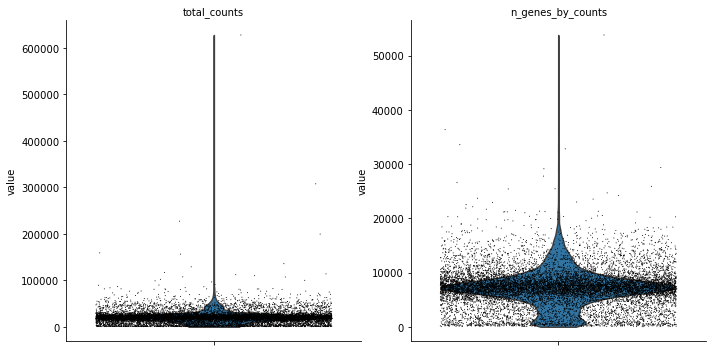

In [7]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

Filter peaks which expression is not detected:

In [8]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=10)
# but does in-place filtering and avoids copying the object

Filter cells:

In [9]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
# This is analogous to 
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

Let's see how the data looks after filtering:

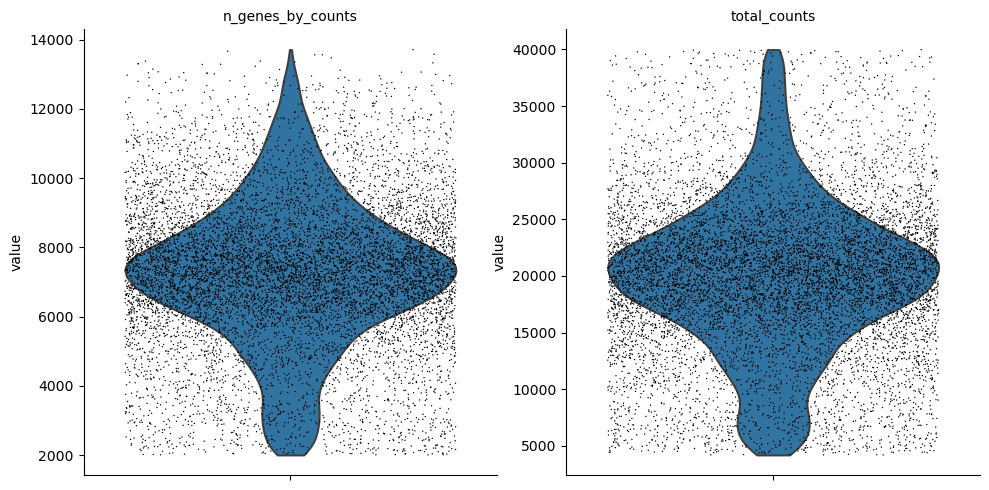

In [10]:
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

Or on histograms:

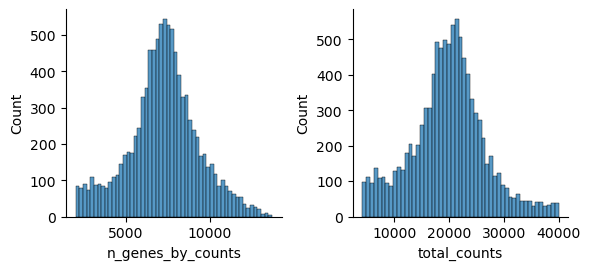

In [11]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])

#### ATAC-specific QC

There are a few expectations about how ATAC-seq data looks like as noted [in the hitchhikerâ€™s guide to ATAC-seq data analysis](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1929-3#citeas) for instance.

##### Nucleosome signal

Fragment size distribution typically reflects nucleosome binding pattern showing enrichment around values corresponding to fragments bound to a single nucleosome (between 147 bp and 294 bp) as well as nucleosome-free fragments (shorter than 147 bp).

In [12]:
atac.obs['NS']=1

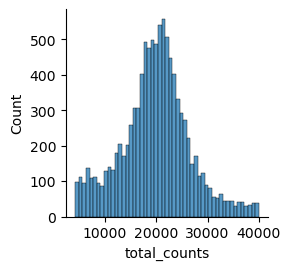

In [13]:
atac.uns

#mdata["atac"].uns
#mdata["atac"].uns["files"]

mu.pl.histogram(atac, [ 'total_counts'])

The ratio of mono-nucleosome cut fragments to nucleosome-free fragments can be called *nucleosome signal*, and it can be estimated using a subset of fragments.

In [14]:
ac.tl.locate_fragments(atac, "data/pbmc10k/atac_fragments.tsv.gz")
ac.tl.nucleosome_signal(atac, n=1e6)

[W::hts_idx_load3] The index file is older than the data file: data/pbmc10k/atac_fragments.tsv.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: data/pbmc10k/atac_fragments.tsv.gz.tbi
Reading Fragments: 100%|██████████| 1000000/1000000 [00:03<00:00, 277729.28it/s]


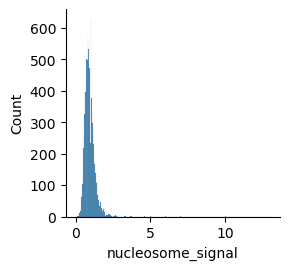

In [15]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)

##### TSS enrichment

We can expect chromatin accessibility enriched around transcription start sites (TSS) compared to accessibility of flanking regions. Thus this measure averaged across multiple genes can serve as one more quality control metric.

The positions of transcription start sites can be obtained from the `interval` field of the gene annotation in the `rna` modality:

In [16]:
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

,Chromosome,Start,End,gene_id,gene_name
AL627309.1,chr1,120931,133723,ENSG00000238009,AL627309.1
AL627309.5,chr1,149706,173862,ENSG00000241860,AL627309.5
AL627309.4,chr1,160445,160446,ENSG00000241599,AL627309.4


TSS enrichment function will return an AnnData object with `cells x bases` dimensions where `bases` correspond to positions around TSS and are defined by `extend_upstream` and `extend_downstream` parameters, each of them being 1000 bp by default. It will also record `tss_score` in the original object.

In [17]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

[W::hts_idx_load3] The index file is older than the data file: data/pbmc10k/atac_fragments.tsv.gz.tbi
Fetching Regions...: 100%|██████████| 1000/1000 [00:43<00:00, 22.78it/s]


In [18]:
tss

AnnData object with n_obs × n_vars = 10069 × 2001
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

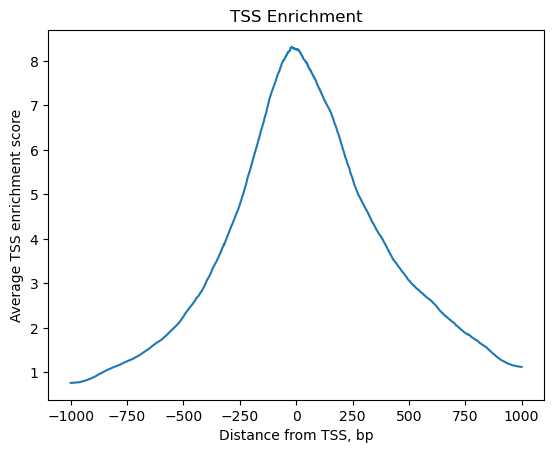

In [19]:
ac.pl.tss_enrichment(tss)

#### Normalisation

In [20]:
# Save original counts
atac.layers["counts"] = atac.X

There can be multiple options for ATAC-seq data normalisation.

One is [latent semantic indexing](https://en.wikipedia.org/wiki/Latent_semantic_analysis) that is frequently used for processing ATAC-seq datasets. First, it constructs term-document matrix from the original count matrix. Then the singular value decomposition (SVD) â€” the same technique that convential principal component analysis uses â€” is used to generate LSI components. Note that there are different flavours of computing TF-IDF, e.g. see [this blog post](http://andrewjohnhill.com/blog/2019/05/06/dimensionality-reduction-for-scatac-data/) about that.

TF-IDF normalisation is implemented in the `muon`'s ATAC module:

```py
ac.pp.tfidf(atac, scale_factor=1e4)
```

Here we will use the same log-normalisation and PCA that we are used to from scRNA-seq analysis. We notice on this data it yields PC & UMAP spaces similar to the one generated on scRNA-seq counts.

In [21]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

#### Feature selection

We will label highly variable peaks that we'll use for downstream analysis.

In [22]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

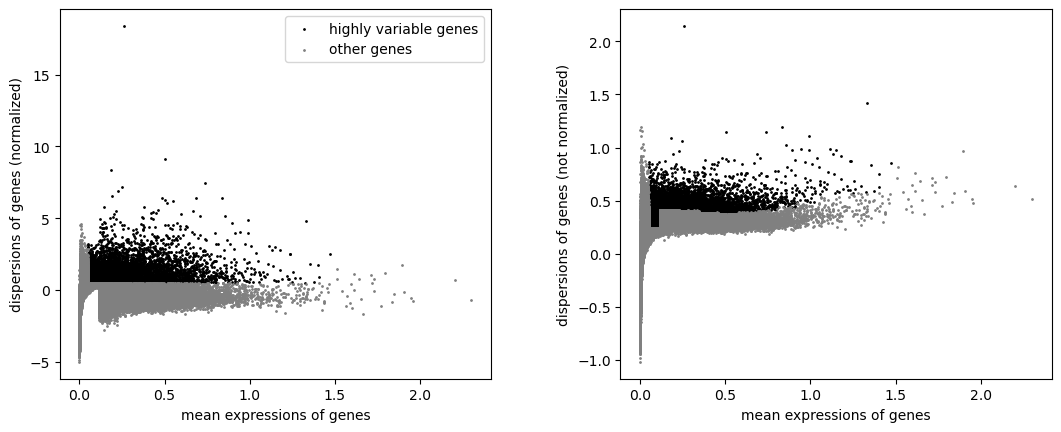

In [23]:
sc.pl.highly_variable_genes(atac)

In [24]:
np.sum(atac.var.highly_variable)

14896

#### Scaling

For uniformity, and for consequent visualisation, we'll save log-transformed counts in a `.raw` slot:

In [25]:
atac.raw = atac

### Analysis

After filtering out low-quality cells, normalising the counts matrix, and selecting highly varianbe peaks, we can already use this data for multimodal integration.

However, as in the case of gene expression, we will study this data individually first and will run PCA on the scaled matrix, compute cell neighbourhood graph, and perform clustering to define cell types. This might be useful later to compare cell type definition between modalities.

#### LSI

When working on TF-IDF counts, `sc.tl.pca` or `ac.tl.lsi` can be used to get latent components, e.g.:

```py
ac.tl.lsi(atac)
```

We find the first component is typically associated with number of peaks or counts per cell so it is reasonable to remove it:

```py
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]
```

The respective neighbourhood graph can be generated with `sc.tl.neighbors`:

```py
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30) 
```

#### PCA

For this notebook, we are using PCA on the log-normalised counts in `atac.X` as described above.

In [26]:
sc.pp.scale(atac)
sc.tl.pca(atac)

We can only colour our plots by cut counts in individual peaks with scanpy:

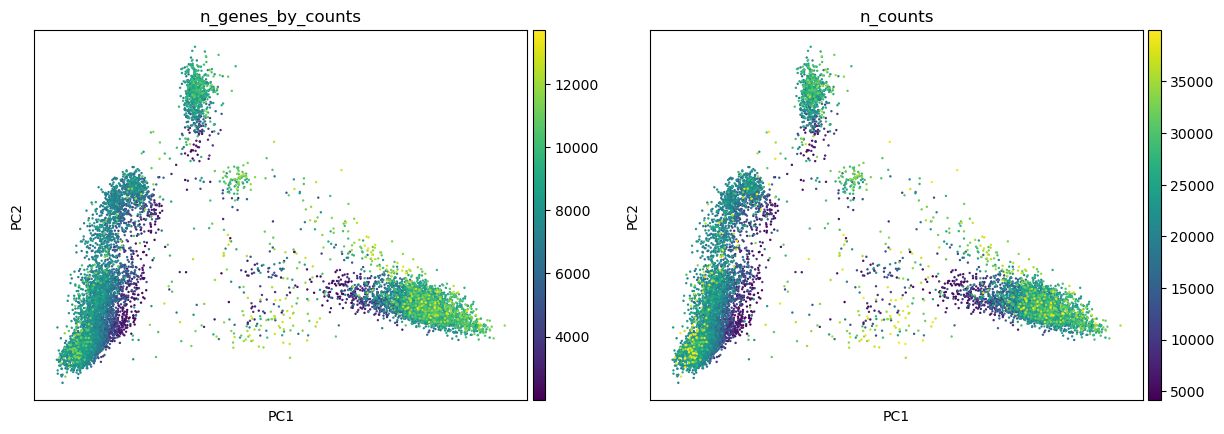

In [27]:
sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"])

With muon's ATAC module, we can plot average values for cut counts in peaks of different types (promoter/distal) that are assigned to respective genes â€” just by providing gene names.

For that to work, we need the peak annotation table with `gene -> peak` correspondence. The `peak_annotation.tsv` file was detected and loaded automatically when we loaded the original data. Here is how the processed peak annotation table looks like:

In [28]:
#atac.uns['atac']['peak_annotation'].tail()

# Alternatively add peak annotation from a TSV file
ac.tl.add_peak_annotation(atac, annotation="data/pbmc10k/atac_peak_annotation.tsv")

Now we can plot average cut values in peaks corresponding to genes just by providing a gene name. By default, values in `atac.raw` are used for plotting.

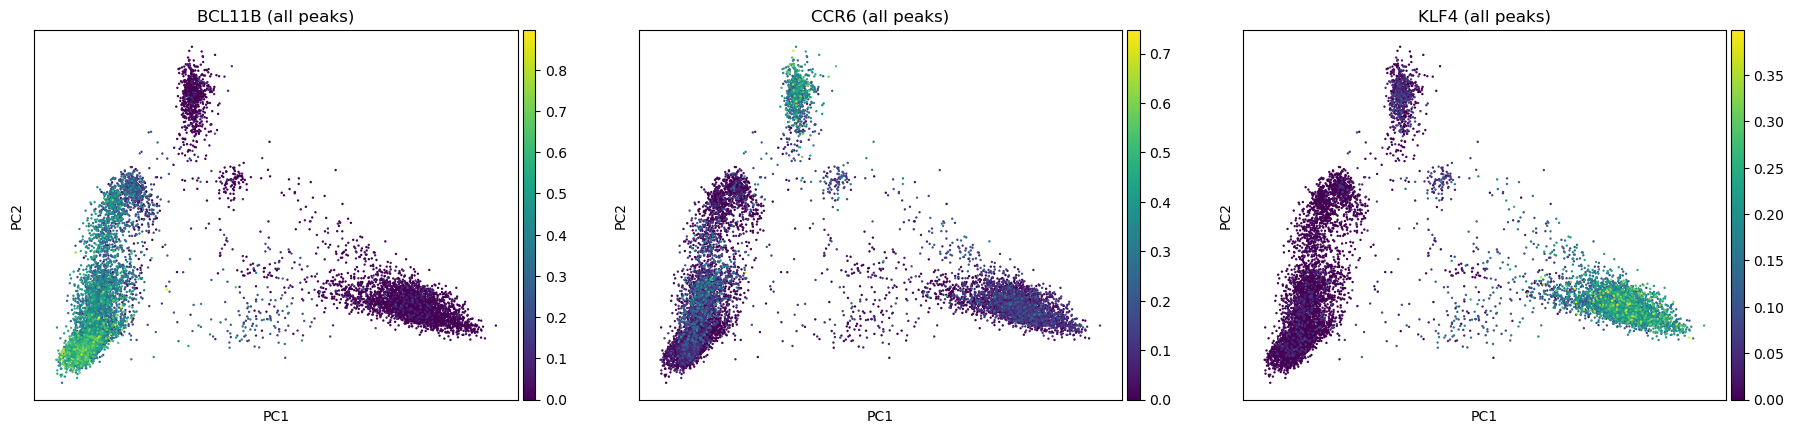

In [29]:
ac.pl.pca(atac, color=["BCL11B", "CCR6", "KLF4"], average="total")

We can also average peaks of each type separately:

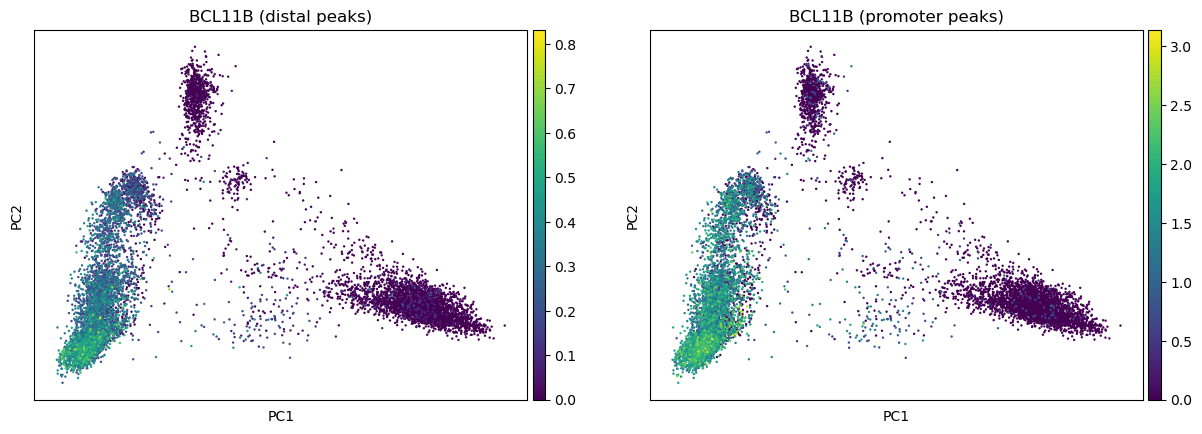

In [30]:
ac.pl.pca(atac, color="BCL11B", average="peak_type")

We see how this component space here resembles the one based on gene expression from the previous notebook. Looking at top loadings of first two components, we see how peaks linked to BCL11B (ENSG00000127152) and KLF4 (ENSG00000136826) demarcate lympohoid / myeloid axis while peaks linked to CCR6 (ENSG00000112486) define B cell axis.

Now we will compute a neighbourhood graph for cells that we'll use for clustering later on.

In [31]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


#### Non-linear dimensionality reduction and clustering

To stay comparable to the gene expression notebook, we will use `leiden` to cluster cells.

In [32]:
sc.tl.leiden(atac, resolution=.5)

We'll use UMAP latent space for visualisation below.

In [33]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)

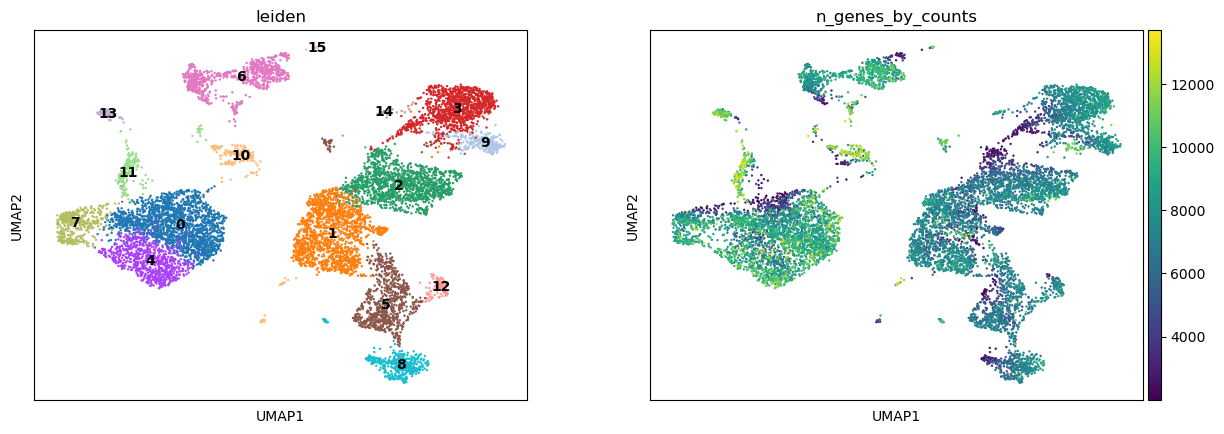

In [34]:
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

Again, we can use the functionality of the ATAC module in `muon` to color plots by cut values in peaks correspoonding to a certain gene:

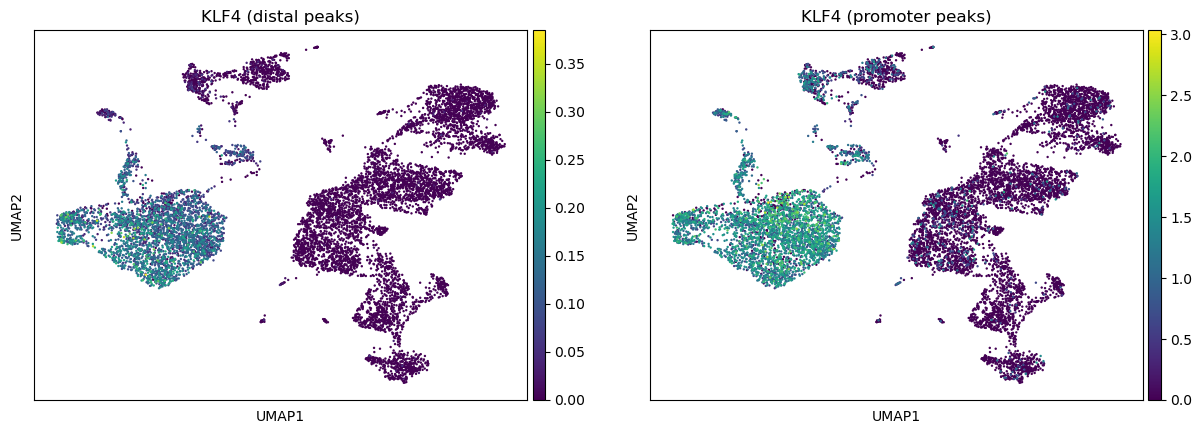

In [35]:
ac.pl.umap(atac, color=["KLF4"], average="peak_type")

#### Marker genes and celltypes

We will now define cell types based on chromatin accessibility.

In [36]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [37]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
#pd.set_option("max_columns", 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

,0_n,0_g,0_p,1_n,1_g,1_p,2_n,2_g,2_p,3_n,...,12_p,13_n,13_g,13_p,14_n,14_g,14_p,15_n,15_g,15_p
0,chr9:107480158-107492721,KLF4,0.000000e+00,chr14:22536559-22563070,"TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...",5.790349e-239,chr14:99255246-99275454,"BCL11B, AL109767.1",6.376147e-240,chr2:86783559-86792275,...,7.670708e-23,chr17:81425658-81431769,BAHCC1,8.694042e-34,chr16:88448143-88480965,ZFPM1,2.133288e-12,chr22:22926399-22936461,IGLC7,2.602093e-08
1,chr11:61953652-61974246,"BEST1, FTH1",0.000000e+00,chr14:99255246-99275454,"BCL11B, AL109767.1",1.728451e-158,chr14:99223600-99254668,"BCL11B, AL109767.1",9.591338e-188,chr11:66311352-66319301,...,1.230698e-22,chr17:3910107-3919628,P2RX1,1.222270e-29,chr14:101807949-101830976,"PPP2R5C, AL137779.2",1.364485e-08,chr10:110353286-110359160,SMNDC1,5.102884e-07
2,chr1:212604203-212626574,"FAM71A, ATF3, AL590648.2",0.000000e+00,chr10:8041366-8062418,"GATA3, GATA3-AS1, AL390294.1",3.380778e-156,chr14:99181080-99219442,"BCL11B, AL162151.1",9.164060e-164,chr14:99255246-99275454,...,1.534262e-22,chr12:108627138-108639115,"SELPLG, AC007569.1",5.350312e-28,chr5:35850992-35860227,IL7R,1.421720e-08,chr1:117653309-117657455,TENT5C,1.223868e-06
3,chr7:106256272-106286624,"NAMPT, AC007032.1",0.000000e+00,chr7:142782798-142813716,"TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...",1.875244e-140,chr7:142782798-142813716,"TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...",4.566544e-161,chr2:136122469-136138482,...,1.149145e-21,chr22:50281096-50284890,PLXNB2,3.843164e-27,chr5:134110288-134135061,TCF7,1.117150e-07,chr2:181303834-181310073,LINC01934,4.285366e-06
4,chr9:134369462-134387253,RXRA,0.000000e+00,chr20:59157931-59168100,ZNF831,1.159095e-128,chr14:22536559-22563070,"TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...",7.240873e-161,chr12:10552886-10555668,...,3.708801e-21,chr6:11730442-11733107,"ADTRP, AL022724.3",8.037829e-27,chr19:16363226-16378669,"EPS15L1, AC020917.3",6.283947e-07,chr20:47414623-47417478,LINC01754,6.489840e-06
5,chr19:13824929-13854962,"ZSWIM4, AC020916.1",0.000000e+00,chr14:99223600-99254668,"BCL11B, AL109767.1",8.987557e-127,chr17:82125073-82129615,CCDC57,3.808348e-145,chr17:82125073-82129615,...,7.367460e-21,chr17:16986865-16990016,LINC02090,2.373697e-26,chr22:39087900-39092994,APOBEC3H,1.207371e-06,chr19:16116910-16120475,RAB8A,1.125913e-05
6,chr3:72092464-72103763,LINC00877,0.000000e+00,chr14:91240967-91256390,"GPR68, AL135818.1",4.138634e-124,chr17:40601555-40611036,SMARCE1,1.681225e-140,chr14:99181080-99219442,...,7.074062e-21,chr20:43681305-43682881,MYBL2,2.832014e-26,chr16:85609841-85617514,GSE1,1.210676e-06,chr11:102473481-102475121,AP001830.2,1.142937e-05
7,chr5:150385442-150415310,"CD74, TCOF1",0.000000e+00,chr5:35850992-35860227,IL7R,9.596896e-122,chr19:16363226-16378669,"EPS15L1, AC020917.3",3.331856e-128,chr14:99223600-99254668,...,7.310865e-21,chr19:50414004-50420358,"POLD1, SPIB",1.255745e-25,chr20:63733192-63743479,"SLC2A4RG, ZGPAT, LIME1",1.598500e-06,chr16:81808702-81811338,PLCG2,1.249782e-05
8,chr6:41268623-41279829,TREM1,6.101572e-318,chr6:37512323-37518673,LINC02520,3.963388e-118,chr11:60977201-60989782,CD6,8.154850e-117,chr7:142782798-142813716,...,8.121393e-21,chr7:98641522-98642532,NPTX2,2.160392e-25,chr14:105856766-105860740,IGHM,2.075807e-06,chr16:81816510-81818969,PLCG2,1.814464e-05
9,chr22:38950570-38958424,APOBEC3A,4.975806e-312,chr10:33135632-33141841,IATPR,7.198315e-116,chr14:61319750-61346673,"PRKCH, AL359220.1",1.882628e-118,chr1:24500773-24509089,...,1.299798e-20,chr6:4281598-4282429,AL159166.1,2.905880e-25,chr17:78107894-78136274,"TNRC6C, TMC6, TMC8, TNRC6C-AS1",2.410034e-06,chr17:16986865-16990016,LINC02090,2.062376e-05


Having studied markers of individual clusters, we will filter some cells out before assigning cell types names to clusters: likely doublets in clusters 10 and 14, proliferating cells in 15, stressed cells in 16.

In [38]:
mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["10", "14", "15", "16"]))
# Analogous to
#   atac = atac[~atac.obs.leiden.isin(["10", "14", "15", "16"])]
# but doesn't copy the object

In [39]:
new_cluster_names = {
    "1": "CD4+ memory T", "2": "CD8+ naÃ¯ve T", "3": "CD4+ naÃ¯ve T",
    "5": "CD8+ activated T", "8": "NK", "12": "MAIT",
    "9": "naÃ¯ve B", "6": "memory B",
    "0": "intermediate mono", "4": "CD14 mono", "7": "CD16 mono",
    "11": "mDC", "13": "pDC",
}

atac.obs['celltype'] = atac.obs.leiden.astype("str").values
atac.obs.celltype = atac.obs.celltype.astype("category").cat.rename_categories(new_cluster_names)

We will also re-order categories for the next plots:

In [40]:
atac.obs.celltype.cat.reorder_categories([
    'CD4+ naÃ¯ve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naÃ¯ve T', 'CD8+ activated T', 'NK',
    'naÃ¯ve B', 'memory B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'mDC', 'pDC'], inplace=True)

/tmp/ipykernel_2907/3369237018.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  atac.obs.celltype.cat.reorder_categories([


... and take colours from a palette:

In [41]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(atac.obs.celltype.cat.categories)))

atac.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

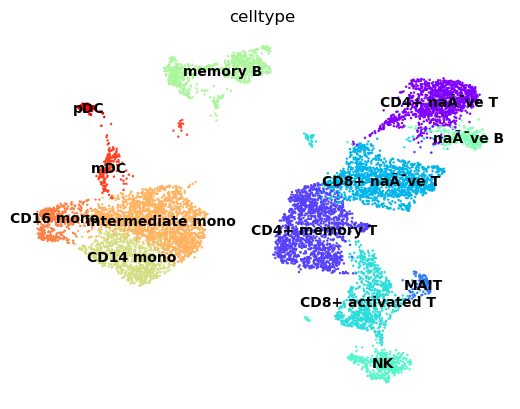

In [42]:
sc.pl.umap(atac, color="celltype", legend_loc="on data", frameon=False)

Finally, we'll visualise some marker genes across cell types.

In [43]:
marker_genes = ['IL7R', 'TRAC',
                'GATA3',
                'SLC4A10',
                'CD8A', 'CD8B', 'CD248', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'TNFRSF13C',
                'IL4R', 'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',
                'FCGR3A', 'MS4A7', 'CST3',
                'CLEC10A', 'IRF8', 'TCF4']

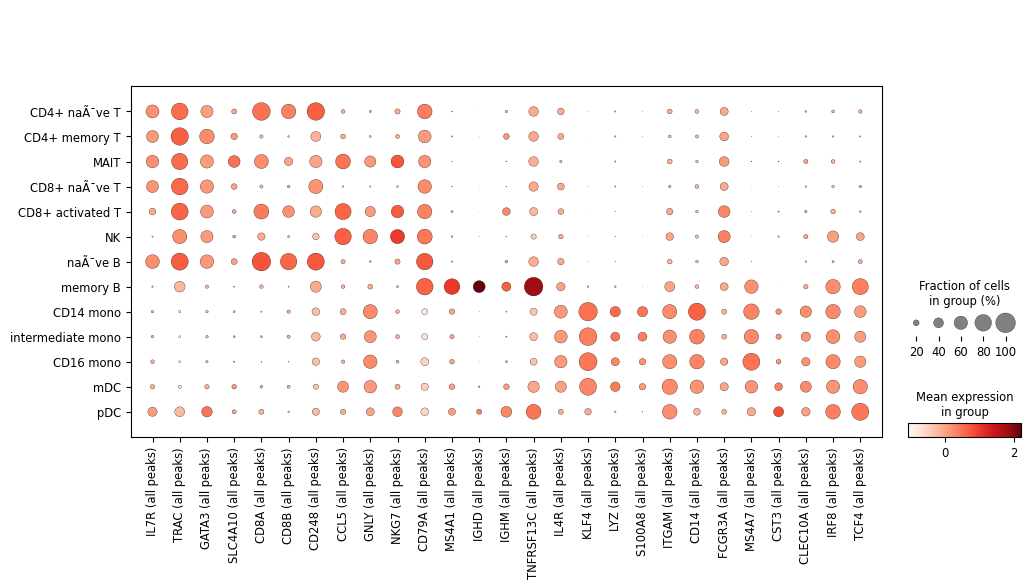

In [44]:
ac.pl.dotplot(atac, marker_genes, groupby='celltype')

## Saving progress on disk

In this chapter, we have been working on the ATAC modality only. We can save our progress into the `.h5mu` file. That will only update the ATAC modality inside the file.

In [45]:
#mu.write("data/pbmc10k.h5mu/atac", atac)

[Next, we'll look into multimodal omics data integration.](3-Multimodal-Omics-Data-Integration.ipynb)


<h1>Export ATAC</h1>

In [46]:
atac
atac_data_dir = "data/atac_data"

In [47]:
atac.X

array([[-0.07574429, -0.11642016, -0.06254829, ..., -0.17619687,
        -0.10740502, -0.13367811],
       [-0.07574429, -0.11642016, -0.06254829, ..., -0.17619687,
        -0.10740502, -0.13367811],
       [-0.07574429, -0.11642016, -0.06254829, ..., -0.17619687,
        -0.10740502, -0.13367811],
       ...,
       [-0.07574429, -0.11642016, -0.06254829, ..., -0.17619687,
        -0.10740502, -0.13367811],
       [-0.07574429, -0.11642016, -0.06254829, ..., -0.17619687,
        -0.10740502, -0.13367811],
       [-0.07574429, -0.11642016, -0.06254829, ..., -0.17619687,
        -0.10740502, -0.13367811]], dtype=float32)

In [48]:
atac.X[0:1000]
atac.var.index[0:400000]

Index(['chr1:10109-10357', 'chr1:180730-181630', 'chr1:191491-191736',
       'chr1:267816-268196', 'chr1:586028-586373', 'chr1:629721-630172',
       'chr1:633793-634264', 'chr1:777634-779926', 'chr1:816881-817647',
       'chr1:819912-823500',
       ...
       'KI270734.1:133761-134101', 'KI270721.1:2341-2736',
       'KI270726.1:27352-27794', 'KI270726.1:41529-42186',
       'KI270713.1:4147-4624', 'KI270713.1:20444-22615',
       'KI270713.1:27118-28927', 'KI270713.1:29485-30706',
       'KI270713.1:31511-32072', 'KI270713.1:37129-37638'],
      dtype='object', length=106086)

In [49]:
#pd.DataFrame(atac.var.index[0:1000]).to_csv(os.path.join(atac_data_dir, "genes_atac.tsv" ), sep = "\t", index=False)

In [50]:
#pd.DataFrame(atac.obs.index[0:1000]).to_csv(os.path.join(atac_data_dir, "barcodes_atac.tsv"), sep = "\t", index = False)

In [58]:
atac_df = atac.to_df()
b_codes = pd.read_csv("./data/rna_data/barcodes_rna_bcells.tsv", sep="\t")
nk_codes = pd.read_csv("./data/rna_data/barcodes_rna_nkcells.tsv", sep="\t")


In [275]:
#atac_df.T.loc[nk_codes.iloc[:,1],:]
#nk = nk_codes.iloc[:,1]
#nk = nk_codes.set_index('0')
nk = nk_codes.rename(columns={'0':''})
b = b_codes.rename(columns={'0':''})

nk2 = nk.set_index('')
b2 = b.set_index('')
codes = b2.append(nk2)
codes


/tmp/ipykernel_2907/3104632387.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  codes = b2.append(nk2)


,Unnamed: 0
,
AAAGCAAGTTAACGGC-1,0
AAAGCACCAGCCTTGG-1,1
AAAGCCCGTCACAGAC-1,2
AAAGCGGGTCATCCTG-1,3
AAAGGAGCACAGAAAC-1,4
...,...
TTTATGGAGTCGCAAT-1,544
TTTCGTCCATGTGGGA-1,545
TTTGCATTCCTTGTTG-1,546


In [277]:
code_names = codes.index.values.tolist()
code_names2 = np.intersect1d(atac_df.index, code_names)
df = atac_df.loc[code_names2,:]

In [278]:
df.T.to_csv(os.path.join(atac_data_dir, "matrix_atac_nk_b.tsv"), sep = "\t")

In [279]:
df.T.describe()


,AAACATGCACCGGCTA-1,AAACATGCAGGGAGCT-1,AAACCGAAGTGAGCAA-1,AAAGCAAGTTAACGGC-1,AAAGCCCGTCACAGAC-1,AAAGCCCGTGTTGCTT-1,AAAGGAGCACAGAAAC-1,AAAGGCTCAATGCCCG-1,AAAGGCTCACAACAAA-1,AAAGGCTCAGGACACA-1,...,TTTCCGGGTGGGTGAA-1,TTTCCTGAGTAACTCA-1,TTTCGTCCATGTGGGA-1,TTTCTCACAGGTTTGC-1,TTTGCATTCTACTAAG-1,TTTGCGGAGGTATTGC-1,TTTGGTAAGTCATGCG-1,TTTGTGGCAAGTGTCC-1,TTTGTGTTCGATAACC-1,TTTGTTGGTTAGGATT-1
count,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000,...,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000,106086.000000
mean,-0.001996,-0.019452,-0.036028,-0.068728,0.032734,-0.019118,0.030348,-0.034000,-0.030764,0.014667,...,0.030053,0.018424,-0.022622,-0.038243,0.062105,-0.002854,-0.003481,-0.022218,0.025289,-0.052207
std,0.991919,0.853232,0.987838,1.132610,0.902790,0.860080,0.995149,0.943188,0.893947,0.999448,...,1.008258,0.985173,1.091517,1.272471,1.027588,1.054720,1.207229,0.869724,1.043421,0.975019
min,-2.445344,-1.978215,-2.603312,-3.237826,-2.107258,-2.235426,-2.071621,-2.303990,-2.598458,-2.445344,...,-2.015183,-2.146288,-3.495276,-3.237826,-2.015183,-2.603312,-2.732317,-2.067395,-2.544036,-2.824670
25%,-0.199874,-0.197837,-0.206902,-0.216838,-0.187513,-0.197214,-0.193026,-0.205099,-0.202222,-0.196020,...,-0.193033,-0.194688,-0.207794,-0.215104,-0.187759,-0.202017,-0.206767,-0.199288,-0.196168,-0.210206
50%,-0.122490,-0.121768,-0.125887,-0.130008,-0.116583,-0.121522,-0.118916,-0.125044,-0.123824,-0.120512,...,-0.119056,-0.119876,-0.126030,-0.129163,-0.116140,-0.123432,-0.125523,-0.122417,-0.120411,-0.127359
75%,-0.084188,-0.083892,-0.086232,-0.088657,-0.080637,-0.083773,-0.082054,-0.085764,-0.085084,-0.083042,...,-0.082130,-0.082708,-0.086336,-0.088167,-0.080202,-0.084786,-0.085976,-0.084329,-0.082930,-0.087109
max,34.374973,28.456675,37.454731,67.746895,21.688934,26.832394,37.306904,26.632462,29.991301,27.222561,...,27.689701,31.465023,42.246429,50.235405,25.323118,28.269815,52.163639,29.090408,27.561102,34.001148
